# Lab 2: Advanced Generative Adversarial Networks (GANs)

---

## Objective
In this lab, you will:
1. Implement a CNN-based GAN for generating realistic images.
2. Explore the use of Transformer-based architectures in GANs for generative
modeling.
3. Compare the performance and visual results of different GAN architectures.
4. Reflect on the strengths and challenges of using CNNs vs. Transformers in GANs.

---

## Background
### Variational Autoencoders (VAEs)
A VAE is a generative model that reconstructs input data by encoding it into a latent space and
then decoding it back. The latent space is a compressed representation that captures the most
important features of the input.
The key elements of a VAE:
- Encoder: Compresses input data into a latent distribution (mean and variance).
- Latent Space: The encoded representation space.
- Reparameterization Trick: Allows gradients to flow through the stochastic latent
space.
- Decoder: Reconstructs the input from the latent space.

### Generative Adversarial Networks (GANs)
A GAN is a generative model consisting of two components:
- Generator: Produces fake data from random noise (latent space).
- Discriminator: Distinguishes between real and fake data.
GANs are trained using an adversarial process where the generator tries to fool the
discriminator, and the discriminator tries to detect fake data.

### Reversing VAEs into GANs
In a conceptual sense:
- A VAE decoder can be seen as a GAN generator.
- The GAN discriminator replaces the VAE encoder by determining the quality of
generated samples instead of encoding input data.

### CNN-based GANs
Convolutional Neural Networks (CNNs) are effective in image processing tasks. In GANs:
- Generator: Uses transpose convolutions to upsample noise into images.
- Discriminator: Uses convolutions to classify images as real or fake.

### Transformer-based GANs
Transformers, traditionally used for NLP, have been adapted for vision tasks (e.g., Vision
Transformers). They model global dependencies between pixels:
- Generator: Uses multi-head self-attention layers to synthesize images.
- Discriminator: Uses similar attention mechanisms to evaluate the generated images.

---

## Part 1: CNN-based GAN
Instructions
1. Implement a CNN Generator:
- Transpose convolution layers to upsample noise into an image.
- Use ReLU activation for hidden layers and Tanh for the output layer.
2. Implement a CNN Discriminator:
- Convolution layers to downsample the input.
- Use LeakyReLU for hidden layers and Sigmoid for the output layer.
3. Train the GAN on the MNIST dataset and generate images.

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, utils as vutils
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
from IPython.display import display, Image as IPyImage

In [2]:
# Parameters and Hyperparameters

batch_size = 128          # Batch size
lr = 0.0002               # Learning rate for Adam
num_epochs = 25           # Number of training epochs
nz = 100                  # Dimension of the latent vector (noise)
ngf = 64                  # Depth factor for the generator (not essential here)
ndf = 64                  # Depth factor for the discriminator

# Device selection (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


1. **batch_size = 128**  
   - This is a classic trade-off between training stability and GPU/CPU memory usage. A larger batch provides a more stable estimate of the gradient, while an excessively large batch might slow down the process or saturate the memory.

2. **lr = 0.0002**  
   - This learning rate is often recommended as a baseline for GANs (and particularly when the DCGAN method is used). It is small enough to ensure stable convergence and avoid excessive oscillations, yet large enough to prevent the training from taking too long.

3. **num_epochs = 25**  
   - For the MNIST dataset, 25 epochs generally yield satisfactory results. This allows the model enough time to converge without risking too much overfitting.

4. **nz = 100**  
   - This is a commonly used dimension for the input noise in GAN literature. It is large enough to capture diversity in the latent space while remaining computationally manageable.

5. **ngf = 64** and **ndf = 64**  
   - These are the "depth factors" for the generator and discriminator. Values of 64 represent a good compromise to capture sufficient details (for 28×28 MNIST images) without making the network too complex or resource-intensive.


In [3]:
# Preparing the MNIST dataset

# Transformation: converting to tensor and normalizing
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Loading the MNIST dataset (train)
dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)


Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:02<00:00, 4.58MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 66.2kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.27MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 10.8MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [4]:
# Definition of the Generator

class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()  # Calls the constructor of the nn.Module class
        self.main = nn.Sequential(
            # First layer: transforms the noise vector (nz x 1 x 1) into a 7x7 feature map
            nn.ConvTranspose2d(nz, 128, kernel_size=7, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(128),  # Applies batch normalization to stabilize training
            nn.ReLU(True),  # ReLU activation to introduce non-linearity

            # Second layer: upsamples the feature map from 7x7 to 14x14
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),  # Batch normalization
            nn.ReLU(True),  # ReLU activation

            # Third layer: upsamples the feature map from 14x14 to 28x28 to match MNIST dimensions
            nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()  # Tanh activation to constrain the output values
        )

    def forward(self, input):
        return self.main(input)  # Applies the defined sequence of layers to the input


In [5]:
# Definition of the Discriminator

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()  # Calls the constructor of the nn.Module class
        self.main = nn.Sequential(
            # First layer: Convolution on the input image (1 channel, 28x28) that reduces its size to 14x14
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),  # LeakyReLU activation with a negative slope of 0.2

            # Second layer: Convolution that further reduces the size to 7x7
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),  # Batch normalization
            nn.LeakyReLU(0.2, inplace=True),  # LeakyReLU activation

            nn.Flatten(),  # Flattens the feature map into a vector
            nn.Linear(128 * 7 * 7, 1),  # Linear layer that produces a single value (realism score)
            nn.Sigmoid()  # Sigmoid activation to convert the score into a probability
        )

    def forward(self, input):
        return self.main(input)  # Applies the sequence of layers to the input

# Instantiation of the Generator and Discriminator and transfer to the chosen device (GPU/CPU)
netG = Generator(nz).to(device)
netD = Discriminator().to(device)


In [6]:
# Weight initialization (according to the DCGAN method)

def weights_init(m):
    classname = m.__class__.__name__  # Retrieves the class name of the layer
    if classname.find('Conv') != -1:  # If the layer is a convolutional layer
        nn.init.normal_(m.weight.data, 0.0, 0.02)  # Initialize weights with a normal distribution
    elif classname.find('BatchNorm') != -1:  # If the layer is a batch normalization layer
        nn.init.normal_(m.weight.data, 1.0, 0.02)  # Initialize weights with a normal distribution centered at 1
        nn.init.constant_(m.bias.data, 0)  # Initialize biases to 0

# Apply the weight initialization to the layers of the Generator and Discriminator
netG.apply(weights_init)
netD.apply(weights_init)


Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Flatten(start_dim=1, end_dim=-1)
    (6): Linear(in_features=6272, out_features=1, bias=True)
    (7): Sigmoid()
  )
)

The DCGAN (Deep Convolutional GAN) method is employed because it provides a convolutional neural network architecture that proves to be particularly stable for training GANs. By using transposed convolution layers for the Generator and standard convolution layers for the Discriminator, DCGAN facilitates the generation of high-resolution images and stabilizes the gradient flow. Moreover, the use of batch normalization (BatchNorm) and the ReLU activation (on the Generator side) or LeakyReLU (on the Discriminator side) helps to maintain smooth training and reduces the risk of mode collapse. This approach has thus proven its effectiveness in producing high-quality results in numerous cases, including on the MNIST dataset.

Source: [DCGAN PyTorch](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html)


In [7]:
# Definition of the loss function and optimizers

criterion = nn.BCELoss()  # Using Binary Cross Entropy as the loss function

# Adam optimizer for the Discriminator with an appropriate learning rate and beta parameters
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(0.5, 0.999))
# Adam optimizer for the Generator
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(0.5, 0.999))

# Defining labels for real and generated images
real_label = 1.  # Numerical label for a real image
fake_label = 0.  # Numerical label for a fake generated image


We use **Binary Cross Entropy (BCE)** because it is a classic loss function that is well-suited to the binary classification task of "real vs. fake". The **Adam optimizers** are favored for their practical efficiency and rapid convergence, especially with the parameters \(beta=0.5\) and \(beta=0.999\) which help stabilize training in GANs. The labels **1 (real)** and **0 (fake)** allow for a direct comparison between the Discriminator’s output (which produces a probability of being real) and the ground truth.


In [8]:
# Training Loop

print("Starting training...")
# To record the evolution of losses and generated images
G_losses = []  # History of Generator losses
D_losses = []  # History of Discriminator losses
img_list = []  # List of image grids generated at the end of each epoch

# Loop over the defined number of epochs
for epoch in range(num_epochs):
    # Loop over batches from the DataLoader
    for i, (data, _) in enumerate(dataloader):

        # Update Discriminator: maximize log(D(x)) + log(1 - D(G(z)))

        netD.zero_grad()  # Reset Discriminator gradients

        # (1) Process real images
        real_images = data.to(device)  # Transfer real images to the device (GPU/CPU)
        b_size = real_images.size(0)  # Get the current batch size
        label = torch.full((b_size,), real_label, device=device)  # Create a tensor with "real" labels
        output = netD(real_images).view(-1)  # Pass real images through the Discriminator and flatten the output
        errD_real = criterion(output, label)  # Compute loss for real images
        errD_real.backward()  # Backpropagate gradients for real images
        D_x = output.mean().item()  # Average of Discriminator outputs on real images (for tracking)

        # (2) Process fake images generated by the Generator
        noise = torch.randn(b_size, nz, 1, 1, device=device)  # Generate a batch of random noise
        fake_images = netG(noise)  # Generate images from the noise using the Generator
        label.fill_(fake_label)  # Assign the "fake" label to generated images
        output = netD(fake_images.detach()).view(-1)  # Pass fake images through the Discriminator
        errD_fake = criterion(output, label)  # Compute loss for fake images
        errD_fake.backward()  # Backpropagate gradients for fake images
        D_G_z1 = output.mean().item()  # Average of Discriminator outputs on fake images

        # Compute the total Discriminator loss and update its weights
        errD = errD_real + errD_fake
        optimizerD.step()  # Update Discriminator parameters

        # Update Generator: fool the Discriminator by maximizing log(D(G(z)))

        netG.zero_grad()  # Reset Generator gradients
        label.fill_(real_label)  # For the Generator, we want the Discriminator to classify generated images as real
        output = netD(fake_images).view(-1)  # Pass fake images through the Discriminator
        errG = criterion(output, label)  # Compute Generator loss
        errG.backward()  # Backpropagate to compute Generator gradients
        D_G_z2 = output.mean().item()  # Average of Discriminator outputs on fake images after Generator update
        optimizerG.step()  # Update Generator parameters

        # Periodically display training losses and statistics
        if i % 100 == 0:
            print(f"[{epoch+1}/{num_epochs}][{i}/{len(dataloader)}] "
                  f"Loss_D: {errD.item():.4f} Loss_G: {errG.item():.4f} "
                  f"D(x): {D_x:.4f} D(G(z)): {D_G_z1:.4f} / {D_G_z2:.4f}")

        # Record the loss values for later analysis
        G_losses.append(errG.item())
        D_losses.append(errD.item())

    # At the end of each epoch, generate a batch of images using fixed noise to observe the Generator's evolution
    with torch.no_grad():  # No gradient computation during image generation for evaluation
        fixed_noise = torch.randn(64, nz, 1, 1, device=device)  # Generate fixed noise
        fake = netG(fixed_noise).detach().cpu()  # Generate images and detach the computation to transfer them to CPU
    img_list.append(vutils.make_grid(fake, padding=2, normalize=True))  # Create an image grid for visualization


Starting training...
[1/25][0/469] Loss_D: 1.5044 Loss_G: 0.7947 D(x): 0.4398 D(G(z)): 0.4837 / 0.4582
[1/25][100/469] Loss_D: 0.4171 Loss_G: 2.6551 D(x): 0.9204 D(G(z)): 0.2765 / 0.0746
[1/25][200/469] Loss_D: 0.2931 Loss_G: 2.4125 D(x): 0.8995 D(G(z)): 0.1651 / 0.0997
[1/25][300/469] Loss_D: 0.3120 Loss_G: 2.3319 D(x): 0.8401 D(G(z)): 0.1233 / 0.1071
[1/25][400/469] Loss_D: 0.2547 Loss_G: 1.8872 D(x): 0.8497 D(G(z)): 0.0710 / 0.1692
[2/25][0/469] Loss_D: 0.2865 Loss_G: 1.8520 D(x): 0.8106 D(G(z)): 0.0601 / 0.1767
[2/25][100/469] Loss_D: 0.3497 Loss_G: 1.8708 D(x): 0.7966 D(G(z)): 0.1047 / 0.1769
[2/25][200/469] Loss_D: 0.5225 Loss_G: 1.4893 D(x): 0.8213 D(G(z)): 0.2663 / 0.2401
[2/25][300/469] Loss_D: 0.5560 Loss_G: 1.8828 D(x): 0.7963 D(G(z)): 0.2596 / 0.1757
[2/25][400/469] Loss_D: 0.3258 Loss_G: 3.4224 D(x): 0.9445 D(G(z)): 0.2250 / 0.0405
[3/25][0/469] Loss_D: 0.4035 Loss_G: 1.6149 D(x): 0.7443 D(G(z)): 0.0725 / 0.2303
[3/25][100/469] Loss_D: 0.5399 Loss_G: 1.6147 D(x): 0.7925 D(

Over the course of the iterations, we observe that the Discriminator’s loss (Loss_D) generally decreases and oscillates around moderate values (approximately between 0.4 and 0.8). This suggests that the Discriminator is gradually becoming more effective at distinguishing real MNIST images from generated ones. When Loss_D exceeds 1, it indicates a moment of difficulty for the Discriminator, but it subsequently decreases, showing that the training process regains its balance.

Meanwhile, the Generator’s loss (Loss_G) exhibits more pronounced fluctuations. At times, it rises (e.g., above 2), indicating that the Discriminator is successfully distinguishing fake images from real ones. However, these increases are followed by drops or values around 1.5 to 2, signaling that the Generator is still managing to improve the quality of its images and continue challenging the Discriminator. The final values of Loss_G and Loss_D, around 1.5 to 2 and 0.4 to 0.6, respectively, indicate a relatively stable training process, where the Generator and Discriminator compete without either completely overpowering the other.

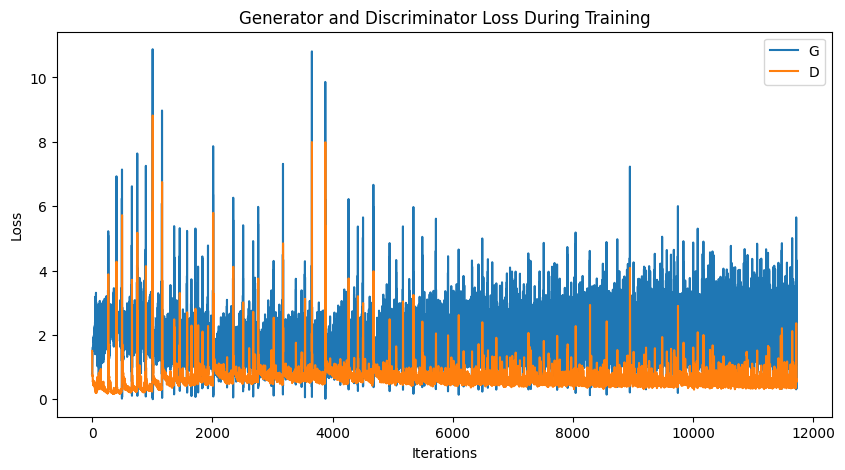

In [9]:
# Displaying the Loss Curves

plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses, label="G")  # Plot the Generator's loss curve
plt.plot(D_losses, label="D")  # Plot the Discriminator's loss curve
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()


We first observe significant fluctuations in the Generator’s loss (blue curve) as well as the Discriminator’s loss (orange curve). Over the course of the iterations, the Discriminator’s loss tends to decrease and then generally stabilizes at lower values, while the Generator’s loss remains higher and shows occasional spikes. These oscillations are normal in GAN training, because the Generator is constantly trying to fool the Discriminator, which adapts in response. The graph indicates that neither model completely dominates the other, suggesting a kind of equilibrium in their confrontation and a gradual learning process.

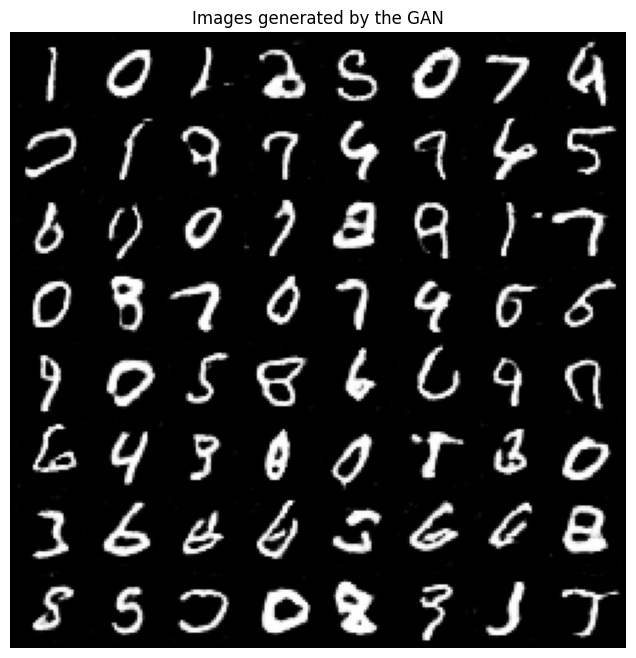

In [10]:
# Visualizing the images generated in the final epoch

plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Images generated by the GAN")
plt.imshow(np.transpose(img_list[-1], (1, 2, 0)))
plt.show()


The numbers generated by the GAN generally resemble MNIST digits, with most of the 0s, 1s, 2s, etc., having recognizable shapes. However, some variations in sharpness and consistency can be observed, indicating that the model is not yet perfect. Despite these imperfections, the overall results suggest that the Generator has learned to produce plausible examples of MNIST digits, validating the overall functionality of the architecture.

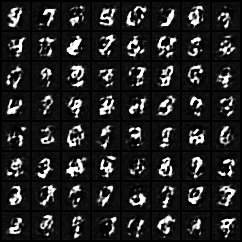

In [15]:
# Create a GIF showing the Generator's progress over epochs
pil_images = []
for epoch_grid in img_list:
    ndarr = epoch_grid.permute(1, 2, 0).cpu().numpy()
    ndarr = (ndarr * 255).astype(np.uint8)
    pil_images.append(Image.fromarray(ndarr))

pil_images[0].save(
    'part1_progress.gif',
    save_all=True,
    append_images=pil_images[1:],
    duration=200,
    loop=0
)

# Pour afficher le GIF dans le notebook
display(IPyImage(filename='part1_progress.gif'))


## Questions

1. **What is Transpose Convolution and why do we use it in the Generator?**  

   Transpose convolution is an operation used to increase the resolution of an image, meaning it performs an "upsampling." In the generator of a GAN, this operation helps transform a low-dimensional representation (e.g., a random vector from the latent space) into a higher-dimensional image. Unlike simple resizing, transpose convolution learns to reconstruct detailed structures while preserving spatial information, which is crucial for generating realistic images.

2. **What are LeakyReLU and Sigmoid, and why do we use them?**  

   LeakyReLU is a nonlinear activation function similar to ReLU, but it allows a small portion of negative values to pass through (typically with a small coefficient, e.g., 0.01), preventing the issue of "dead" neurons that stop updating during training. This function is often used in the hidden layers of GANs to facilitate learning by maintaining an information flow even for negative inputs.  
   
   The Sigmoid function, on the other hand, compresses input values into the range \([0,1]\) and is commonly used in the output layer (e.g., in the discriminator) to produce a probability estimate indicating whether an image is real or generated. This allows the network's output to be easily interpreted within a probabilistic framework.

3. **Read the code and comment on every line.**  

   Check the code.

---

## Part 2: Transformer-based GAN
Instructions
1. Implement a Transformer Generator:
- Use Multi-Head Self-Attention (MHSA) and positional encodings.
- Upsample the latent space using feedforward layers.
2. Implement a Transformer Discriminator:
- Use MHSA to analyze global relationships in the input.
- Classify real vs. fake images.
3. Train the Transformer-based GAN on MNIST and compare its performance to the CNNbased GAN.


In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, utils as vutils
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from IPython.display import Image as IPyImage

In [17]:
# Parameters and Hyperparameters

batch_size = 128                      # Number of images per batch
lr = 0.0002                           # Learning rate for optimizers
num_epochs = 25                       # Total number of training epochs
nz = 100                              # Dimension of the latent vector (noise)
num_tokens = 16                       # Number of tokens (will form a 4x4 grid)
d_model = 128                         # Dimension of Transformer embeddings
num_heads = 4                         # Number of attention heads in the Transformer
num_layers = 4                        # Number of Transformer Encoder layers
patch_size = 7                        # Size of each image patch (7x7); 4 patches of 7 pixels each make 28
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


1. **batch_size = 128**  
   - This is a classic trade-off between training stability and GPU/CPU memory usage. A larger batch provides a more stable estimate of the gradient, while an excessively large batch might slow down the process or saturate the memory.

2. **lr = 0.0002**  
   - This learning rate is often recommended as a baseline for GANs (and particularly when the DCGAN method is used). It is small enough to ensure stable convergence and avoid excessive oscillations, yet large enough to prevent the training from taking too long.

3. **num_epochs = 25**  
   - For the MNIST dataset, 25 epochs generally yield satisfactory results. This allows the model enough time to converge without risking too much overfitting.

4. **nz = 100**  
   - This is a commonly used dimension for the input noise in GAN literature. It is large enough to capture diversity in the latent space while remaining computationally manageable.
   
5. **num_tokens = 16**  
   - En divisant l'image de 28×28 en 16 patchs (4×4), chaque patch est considéré comme un « token » dans le Transformer. Cette représentation permet de traiter chaque région de l'image de façon indépendante, puis de capturer globalement leurs relations via l'attention.

6. **d_model = 128**  
   - Il s’agit de la dimension des embeddings au sein du Transformeur. Un d_model plus élevé permettrait au modèle de capturer plus de complexité, au prix de coûts en calcul et en mémoire plus importants.

7. **num_heads = 4**  
   - Le multi-head attention est scindé en 4 têtes. Cela permet au modèle de se focaliser simultanément sur différentes zones de l’image ou différentes représentations spatiales et d’extraire des informations diversifiées.

8. **num_layers = 4**  
   - Le Transformer est empilé sur 4 couches. Chaque couche supplémentaire approfondit la capacité du modèle à repérer des motifs plus abstraits, bien que davantage de couches rallongent le temps d’entraînement.

9. **patch_size = 7**  
   - Chaque patch de 7×7 pixels correspond à un token. La taille 7 est choisie pour obtenir précisément 4 patchs en hauteur et en largeur (4×7=28), ce qui s’accorde avec la résolution de MNIST.



In [18]:
# Preparing the MNIST dataset

transform = transforms.Compose([
    transforms.ToTensor(),            # Convert images to PyTorch tensors
    transforms.Normalize((0.5,), (0.5,))  # Normalize images to the range [-1, 1]
])
dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)  # Load the MNIST training set
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)  # Create a DataLoader for batching


In [19]:
# Define the Transformer Generator

class TransformerGenerator(nn.Module):
    def __init__(self, nz, num_tokens=16, d_model=128, num_heads=4, num_layers=4, patch_size=7):
        super(TransformerGenerator, self).__init__()  # Initialize the parent class
        self.num_tokens = num_tokens  # Number of tokens (image patches)
        self.d_model = d_model  # Transformer embedding dimension

        # Project the latent vector to a sequence of tokens (flattened)
        self.linear_proj = nn.Linear(nz, num_tokens * d_model)
        # Learnable positional embeddings to add spatial information to tokens
        self.pos_embedding = nn.Parameter(torch.randn(1, num_tokens, d_model))

        # Define a Transformer Encoder with a specified number of layers and attention heads
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=num_heads)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Map each token to a flattened image patch
        self.token_to_patch = nn.Linear(d_model, patch_size * patch_size)
        self.patch_size = patch_size  # Store patch size
        # Calculate grid size assuming tokens form a square grid
        self.grid_size = int(num_tokens**0.5)
        # Ensure that grid_size * patch_size equals the image size (28)
        assert self.grid_size * self.patch_size == 28, "grid_size * patch_size must equal 28"

    def forward(self, z):
        batch_size = z.size(0)  # Get the current batch size
        # Project the latent vector into a sequence of tokens: shape (batch, num_tokens*d_model)
        tokens = self.linear_proj(z)
        # Reshape tokens to (batch, num_tokens, d_model)
        tokens = tokens.view(batch_size, self.num_tokens, self.d_model)
        # Add positional embeddings to tokens
        tokens = tokens + self.pos_embedding
        # Transpose tokens to shape (num_tokens, batch, d_model) as required by the Transformer
        tokens = tokens.transpose(0, 1)
        # Pass tokens through the Transformer Encoder
        tokens = self.transformer_encoder(tokens)
        # Transpose tokens back to (batch, num_tokens, d_model)
        tokens = tokens.transpose(0, 1)
        # Map each token to a flattened image patch: shape (batch, num_tokens, patch_size*patch_size)
        patches = self.token_to_patch(tokens)
        # Reshape patches into a grid: (batch, grid_size, grid_size, patch_size, patch_size)
        patches = patches.view(batch_size, self.grid_size, self.grid_size, self.patch_size, self.patch_size)
        # Rearrange patches to reconstruct the image: (batch, 1, 28, 28)
        images = patches.permute(0, 1, 3, 2, 4).contiguous()
        images = images.view(batch_size, 1, self.grid_size * self.patch_size, self.grid_size * self.patch_size)
        # Apply Tanh activation to constrain the output values to [-1, 1]
        images = torch.tanh(images)
        return images  # Return the generated images

In [20]:
# Define the Transformer Discriminator

class TransformerDiscriminator(nn.Module):
    def __init__(self, d_model=128, num_heads=4, num_layers=4, patch_size=7, image_size=28):
        super(TransformerDiscriminator, self).__init__()  # Initialize the parent class
        self.patch_size = patch_size  # Patch size
        self.grid_size = image_size // patch_size  # Calculate grid size (28/7 = 4)
        self.num_tokens = self.grid_size * self.grid_size  # Total number of tokens (patches)
        self.patch_dim = patch_size * patch_size  # Flattened patch dimension

        # Linear layer to project each flattened patch into the embedding space
        self.linear_patch = nn.Linear(self.patch_dim, d_model)
        # Learnable positional embeddings for the patches
        self.pos_embedding = nn.Parameter(torch.randn(1, self.num_tokens, d_model))

        # Define a Transformer Encoder to analyze global relationships among patches
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=num_heads)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Final classifier: map aggregated token representation to a single probability (real/fake)
        self.classifier = nn.Linear(d_model, 1)

    def forward(self, x):
        batch_size = x.size(0)  # Get the current batch size
        x = x.squeeze(1)  # Remove the channel dimension; shape becomes (batch, 28, 28)
        # Extract patches from the image using unfold, resulting in a tensor of shape (batch, num_tokens, patch_dim)
        patches = x.unfold(1, self.patch_size, self.patch_size).unfold(2, self.patch_size, self.patch_size)
        patches = patches.contiguous().view(batch_size, -1, self.patch_size * self.patch_size)
        # Project each patch into the Transformer embedding space
        tokens = self.linear_patch(patches)
        # Add positional embeddings to the tokens
        tokens = tokens + self.pos_embedding
        # Transpose tokens to shape (num_tokens, batch, d_model) for the Transformer
        tokens = tokens.transpose(0, 1)
        # Pass tokens through the Transformer Encoder
        tokens = self.transformer_encoder(tokens)
        # Transpose tokens back to (batch, num_tokens, d_model)
        tokens = tokens.transpose(0, 1)
        # Aggregate tokens by computing their mean (simple average)
        tokens = tokens.mean(dim=1)
        # Classify the aggregated token representation using a linear layer and sigmoid activation to get a probability
        out = self.classifier(tokens)
        out = torch.sigmoid(out)
        return out  # Return the probability of the image being real

In [21]:
# Instantiate the models and move them to the selected device (GPU/CPU)

netG_trans = TransformerGenerator(nz, num_tokens, d_model, num_heads, num_layers, patch_size).to(device)
netD_trans = TransformerDiscriminator(d_model, num_heads, num_layers, patch_size, image_size=28).to(device)


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [22]:
# Define the loss function and optimizers
criterion = nn.BCELoss()  # Binary Cross Entropy loss for GAN training
optimizerD = optim.Adam(netD_trans.parameters(), lr=lr, betas=(0.5, 0.999))  # Adam optimizer for Discriminator
optimizerG = optim.Adam(netG_trans.parameters(), lr=lr, betas=(0.5, 0.999))  # Adam optimizer for Generator

real_label = 1.  # Label for real images
fake_label = 0.  # Label for fake images

In [23]:
# Training loop for the Transformer-based GAN
print("Starting Transformer-based GAN training...")
G_losses_trans = []   # List to store Generator losses
D_losses_trans = []   # List to store Discriminator losses
img_list_trans = []   # List to store image grids generated at each epoch

for epoch in range(num_epochs):  # Loop over epochs
    for i, (data, _) in enumerate(dataloader):  # Loop over DataLoader batches

        # Update Discriminator: maximize log(D(real)) + log(1 - D(fake))

        netD_trans.zero_grad()  # Zero the gradients for Discriminator
        real_images = data.to(device)  # Move real images to the device
        b_size = real_images.size(0)  # Get batch size
        label = torch.full((b_size, 1), real_label, device=device)  # Create labels for real images
        output = netD_trans(real_images)  # Compute Discriminator output on real images
        errD_real = criterion(output, label)  # Compute loss on real images
        errD_real.backward()  # Backpropagate the loss for real images
        D_x = output.mean().item()  # Calculate average Discriminator output on real images

        noise = torch.randn(b_size, nz, device=device)  # Generate random noise for Generator input
        fake_images = netG_trans(noise)  # Generate fake images from noise
        label.fill_(fake_label)  # Set labels to fake for generated images
        output = netD_trans(fake_images.detach())  # Compute Discriminator output on fake images
        errD_fake = criterion(output, label)  # Compute loss on fake images
        errD_fake.backward()  # Backpropagate the loss for fake images
        D_G_z1 = output.mean().item()  # Calculate average Discriminator output on fake images before Generator update

        errD = errD_real + errD_fake  # Total Discriminator loss
        optimizerD.step()  # Update Discriminator weights


        # Update Generator: maximize log(D(G(z)))

        netG_trans.zero_grad()  # Zero the gradients for Generator
        label.fill_(real_label)  # Set labels to real for Generator loss
        output = netD_trans(fake_images)  # Compute Discriminator output on fake images
        errG = criterion(output, label)  # Compute Generator loss
        errG.backward()  # Backpropagate the Generator loss
        D_G_z2 = output.mean().item()  # Calculate average Discriminator output on fake images after Generator update
        optimizerG.step()  # Update Generator weights

        # Print training status every 100 batches
        if i % 100 == 0:
            print(f"[{epoch+1}/{num_epochs}][{i}/{len(dataloader)}] "
                  f"Loss_D: {errD.item():.4f} Loss_G: {errG.item():.4f} "
                  f"D(x): {D_x:.4f} D(G(z)): {D_G_z1:.4f}/{D_G_z2:.4f}")

        G_losses_trans.append(errG.item())  # Record Generator loss
        D_losses_trans.append(errD.item())  # Record Discriminator loss

    # At the end of each epoch, generate a grid of fake images to monitor Generator progress
    with torch.no_grad():
        fixed_noise = torch.randn(64, nz, device=device)  # Generate fixed noise
        fake = netG_trans(fixed_noise).detach().cpu()  # Generate fake images and move them to CPU
    img_list_trans.append(vutils.make_grid(fake, padding=2, normalize=True))  # Create and store an image grid

print("Transformer-based GAN training complete.")

Starting Transformer-based GAN training...
[1/25][0/469] Loss_D: 1.4171 Loss_G: 1.0226 D(x): 0.4660 D(G(z)): 0.4793/0.3600
[1/25][100/469] Loss_D: 0.9949 Loss_G: 1.0020 D(x): 0.5386 D(G(z)): 0.2983/0.3693
[1/25][200/469] Loss_D: 0.7045 Loss_G: 1.3640 D(x): 0.7452 D(G(z)): 0.3271/0.2566
[1/25][300/469] Loss_D: 1.0898 Loss_G: 0.9507 D(x): 0.6034 D(G(z)): 0.4131/0.3879
[1/25][400/469] Loss_D: 1.3722 Loss_G: 0.8715 D(x): 0.4130 D(G(z)): 0.3831/0.4186
[2/25][0/469] Loss_D: 1.1698 Loss_G: 1.1504 D(x): 0.5869 D(G(z)): 0.4274/0.3179
[2/25][100/469] Loss_D: 1.2445 Loss_G: 2.1494 D(x): 0.9070 D(G(z)): 0.6497/0.1169
[2/25][200/469] Loss_D: 0.5094 Loss_G: 1.4166 D(x): 0.8846 D(G(z)): 0.2872/0.2442
[2/25][300/469] Loss_D: 0.5579 Loss_G: 1.6720 D(x): 0.8163 D(G(z)): 0.2782/0.1915
[2/25][400/469] Loss_D: 2.1316 Loss_G: 2.1488 D(x): 0.8066 D(G(z)): 0.7936/0.1176
[3/25][0/469] Loss_D: 0.9394 Loss_G: 1.0187 D(x): 0.6714 D(G(z)): 0.4012/0.3630
[3/25][100/469] Loss_D: 0.0941 Loss_G: 2.9934 D(x): 0.9655 D(

The training process exhibits a learning dynamic typical of GANs. Initially, the Discriminator’s loss (Loss_D) is relatively high, indicating that the model struggles to distinguish real images from generated ones. The Generator’s loss (Loss_G) fluctuates, meaning that the Generator is attempting to improve the quality of its generated images to deceive the Discriminator.

As training progresses over multiple epochs, the Discriminator’s loss gradually decreases and stabilizes around moderate values, suggesting that it becomes better at identifying synthetic images. Meanwhile, the Generator’s loss varies significantly, sometimes spiking at certain stages, indicating phases of improvement followed by difficulties in maintaining consistent image quality.

Towards the end of training, the loss values become more stable, although the Discriminator’s loss remains slightly higher, reflecting a relative balance between the two networks. However, some fluctuations persist, showing that the GAN has not fully converged and that the training process could benefit from hyperparameter adjustments or a higher number of epochs.

At the beginning of training, the Discriminator’s loss (Loss_D) is relatively high and fluctuates, while the Generator’s loss (Loss_G) remains moderate. This reflects a phase where the Discriminator is gradually learning to recognize real samples, and the Generator is still trying to produce credible images. Soon, Loss_G increases and can reach high values (sometimes exceeding 3 or 4), indicating that the Generator is becoming more effective at deceiving the Discriminator. Simultaneously, significant drops in Loss_D are observed at certain stages, suggesting that the Discriminator is also adapting and maintaining its ability to differentiate between real and fake samples.

Finally, in the last iterations, Loss_D remains low while Loss_G remains high, indicating a Generator that is confident in its samples and a Discriminator that is often “fooled” by them. This suggests that the Transformer-GAN is successfully generating high-quality digits that closely resemble real MNIST numbers.

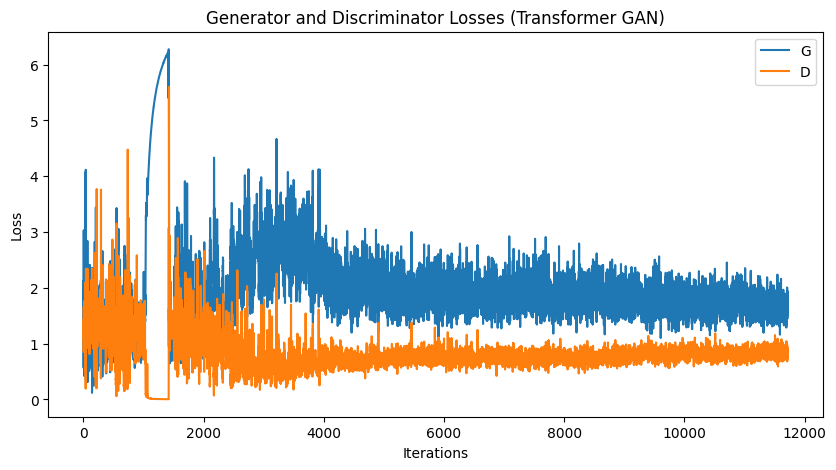

In [24]:
# Plot the loss curves for Generator and Discriminator

plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Losses (Transformer GAN)")
plt.plot(G_losses_trans, label="G") # Plot the Generator's loss curve
plt.plot(D_losses_trans, label="D") # Plot the Descriminator's loss curve
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

Initially, the Generator’s loss increases sharply, indicating that it struggles to produce realistic images, while the Discriminator’s loss decreases rapidly, showing that it effectively distinguishes real images from fake ones. After this unstable phase, a relative equilibrium sets in, with typical GAN oscillations. The Generator’s loss remains generally higher, suggesting that it still has difficulty deceiving the Discriminator, but the trend indicates a gradual stabilization of the learning process.

At the beginning, both loss curves (G and D) fluctuate significantly, signaling that the Discriminator and Generator are adjusting to each other. Gradually, the Discriminator’s loss (D) decreases and stabilizes further, indicating that it is becoming more efficient at detecting fake samples. Meanwhile, the Generator’s loss (G) oscillates at relatively higher values, showing that it must continuously improve its samples to deceive an increasingly effective Discriminator. These oscillations demonstrate that both models push each other to improve continuously.

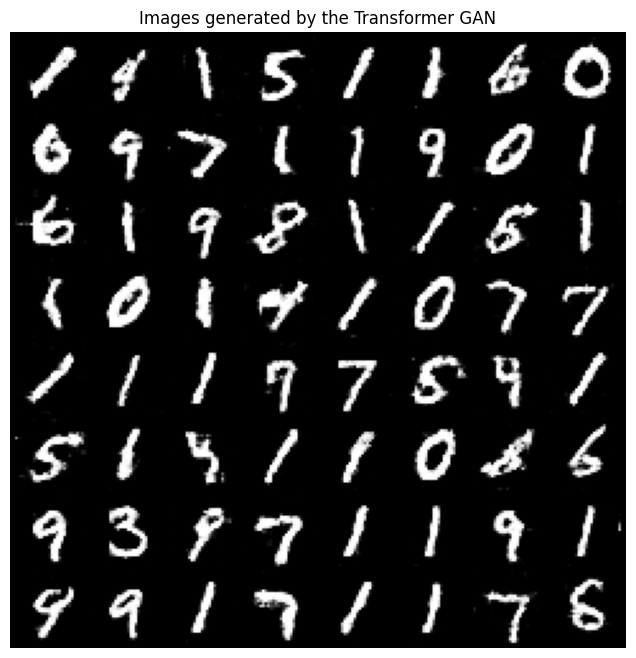

In [25]:
# Visualize the generated images from the last epoch

plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Images generated by the Transformer GAN")
plt.imshow(np.transpose(img_list_trans[-1], (1, 2, 0)))
plt.show()

The images generated by the Transformer GAN display recognizable digits, indicating that the model has learned some features from the MNIST dataset. However, distortions and irregular shapes can be observed, suggesting that the generation process is not yet fully stable. Some digits appear clear, while others are blurry or poorly formed, indicating that the Generator still struggles to capture fine details. The training process could benefit from adjustments such as increasing the number of epochs or improving regularization to enhance the quality of the generated images.

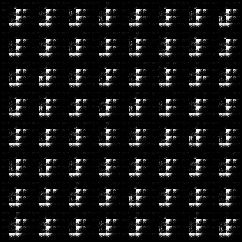

In [26]:
# Create a GIF showing the Generator's progress over epochs
pil_images_trans = []
for epoch_grid in img_list_trans:
    ndarr = epoch_grid.permute(1, 2, 0).cpu().numpy()
    ndarr = (ndarr * 255).astype(np.uint8)
    pil_images_trans.append(Image.fromarray(ndarr))

pil_images_trans[0].save(
    'part2_transformer_progress.gif',
    save_all=True,
    append_images=pil_images_trans[1:],
    duration=200,
    loop=0
)

IPyImage(filename='part2_transformer_progress.gif')

---

## 3. GAN Model and Training
The GAN combines the Transformer Generator and Discriminator, with adversarial training to
improve both.
### TO DO: Implement the Gan model using both Generator and Discriminator.
Hint : get inspired from the solution given for CNN-based GAN.

In [39]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, utils as vutils
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from IPython.display import Image as IPyImage


In [40]:
# Paramètres et Hyperparamètres

batch_size = 128       # Number of images per batch
lr = 0.0002            # Learning rate for optimizers
num_epochs = 25        # Total number of training epochs
nz = 100               # Latent vector dimension (noise)
num_tokens = 16        # Number of tokens (for a 4x4 grid)
d_model = 128          # Dimension of the Transformer's embeddings
num_heads = 4          # Number of heads in the Multi-Head Self-Attention
num_layers = 4         # Number of layers in the Transformer Encoder
patch_size = 7         # Each patch will be 7x7 pixels (4x7 = 28)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [41]:
# Preparation of the MNIST dataset

# Compose a series of transformations: convert images to tensors and normalize them.
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor.
    transforms.Normalize((0.5,), (0.5,))  # Normalize the tensor with mean=0.5 and std=0.5.
])

# Load the MNIST training dataset
dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Create a DataLoader to iterate through the dataset in batches, shuffle the data, and use 2 worker threads for loading.
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)


In [42]:
# Definition of the Transformer Generator

class TransformerGenerator(nn.Module):
    def __init__(self, nz, num_tokens=16, d_model=128, num_heads=4, num_layers=4, patch_size=7):
        super(TransformerGenerator, self).__init__()  # Initialize the parent nn.Module
        self.num_tokens = num_tokens  # Store the number of tokens
        self.d_model = d_model  # Store the dimension of each token

        # Project the latent vector into a token sequence
        self.linear_proj = nn.Linear(nz, num_tokens * d_model)  # Map latent vector (nz) to a sequence of tokens

        # Positional embeddings (learned)
        self.pos_embedding = nn.Parameter(torch.randn(1, num_tokens, d_model))  # Learnable positional embeddings

        # Definition of the Transformer Encoder
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=num_heads)  # Create one Transformer encoder layer
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)  # Stack encoder layers

        # Convert each token into a flattened patch
        self.token_to_patch = nn.Linear(d_model, patch_size * patch_size)  # Map each token to a flattened image patch
        self.patch_size = patch_size  # Store the patch size
        # Assuming that num_tokens forms a square grid
        self.grid_size = int(num_tokens**0.5)  # Calculate grid size from the number of tokens
        assert self.grid_size * self.patch_size == 28, "grid_size * patch_size must equal 28"  # Ensure the final image size is 28x28

    def forward(self, z):
        batch_size = z.size(0)  # Get the batch size from the latent vector

        # Project the latent vector: (batch, num_tokens*d_model)
        tokens = self.linear_proj(z)  # Map the latent vector to a sequence of tokens

        # Reshape into (batch, num_tokens, d_model)
        tokens = tokens.view(batch_size, self.num_tokens, self.d_model)  # Reshape to separate tokens and their features

        # Add positional embeddings
        tokens = tokens + self.pos_embedding  # Add learned positional information to the tokens

        # Pass through the Transformer Encoder: transpose to (seq_len, batch, d_model)
        tokens = tokens.transpose(0, 1)  # Transpose tokens to (sequence length, batch, d_model) for the encoder
        tokens = self.transformer_encoder(tokens)  # Process tokens with the Transformer encoder
        tokens = tokens.transpose(0, 1)  # Transpose back to (batch, num_tokens, d_model)

        # Convert each token into a flattened patch
        patches = self.token_to_patch(tokens)  # Map each token to a flattened patch (batch, num_tokens, patch_size*patch_size)

        # Reshape into a grid: (batch, grid_size, grid_size, patch_size, patch_size)
        patches = patches.view(batch_size, self.grid_size, self.grid_size, self.patch_size, self.patch_size)  # Arrange patches in a grid

        # Rearrange to obtain the final image: (batch, 1, 28, 28)
        images = patches.permute(0, 1, 3, 2, 4).contiguous()  # Permute dimensions to merge patches correctly
        images = images.view(batch_size, 1, self.grid_size * self.patch_size, self.grid_size * self.patch_size)  # Reshape to final image dimensions

        # Tanh to constrain values in [-1, 1]
        images = torch.tanh(images)  # Apply tanh activation to scale output between -1 and 1

        return images  # Return the generated images


In [43]:
# Definition of the Transformer Discriminator

class TransformerDiscriminator(nn.Module):
    def __init__(self, d_model=128, num_heads=4, num_layers=4, patch_size=7, image_size=28):
        super(TransformerDiscriminator, self).__init__()  # Initialize the parent nn.Module
        self.patch_size = patch_size  # Save the patch size
        self.grid_size = image_size // patch_size  # Compute grid size (28/7 = 4)
        self.num_tokens = self.grid_size * self.grid_size  # Total tokens (4x4 = 16)
        self.patch_dim = patch_size * patch_size  # Dimension of a flattened patch

        # Project each flattened patch into the embedding space
        self.linear_patch = nn.Linear(self.patch_dim, d_model)
        # Create learnable positional embeddings for each token
        self.pos_embedding = nn.Parameter(torch.randn(1, self.num_tokens, d_model))

        # Create a Transformer encoder to capture global relationships among tokens
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=num_heads)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Final classifier that aggregates token information to output a single value
        self.classifier = nn.Linear(d_model, 1)

    def forward(self, x):
        batch_size = x.size(0)  # Get the batch size
        x = x.squeeze(1)  # Remove the channel dimension: (batch, 28, 28)
        # Divide each image into patches: result shape -> (batch, num_tokens, patch_dim)
        patches = x.unfold(1, self.patch_size, self.patch_size).unfold(2, self.patch_size, self.patch_size)
        patches = patches.contiguous().view(batch_size, -1, self.patch_size * self.patch_size)
        # Project each patch into the embedding space: (batch, num_tokens, d_model)
        tokens = self.linear_patch(patches)
        # Add positional embeddings to the tokens
        tokens = tokens + self.pos_embedding
        # Rearrange tokens for the Transformer: (num_tokens, batch, d_model)
        tokens = tokens.transpose(0, 1)
        # Process tokens with the Transformer encoder
        tokens = self.transformer_encoder(tokens)
        # Transpose tokens back to (batch, num_tokens, d_model)
        tokens = tokens.transpose(0, 1)
        # Aggregate tokens by averaging across the token dimension: (batch, d_model)
        tokens = tokens.mean(dim=1)
        # Classify the aggregated representation using a linear layer and sigmoid activation: (batch, 1)
        out = self.classifier(tokens)
        out = torch.sigmoid(out)
        return out  # Return the final discriminator output


In [44]:
# Definition of a class that encompasses the GAN (Generator + Discriminator) and the training logic

class GANModel:
    def __init__(self, netG, netD, criterion, optimizerG, optimizerD, device):
        # Initialize the GAN with its generator, discriminator, loss function, optimizers, and device.
        self.netG = netG              # Generator network
        self.netD = netD              # Discriminator network
        self.criterion = criterion    # Loss function (e.g., Binary Cross Entropy)
        self.optimizerG = optimizerG  # Optimizer for the generator
        self.optimizerD = optimizerD  # Optimizer for the discriminator
        self.device = device          # Device to run the computations (CPU or GPU)

    def train_step(self, real_images, noise):
        batch_size = real_images.size(0)  # Get the batch size from the real images

        # Create labels for real and fake images
        real_labels = torch.full((batch_size, 1), 1.0, device=self.device)  # Label tensor filled with 1's for real images
        fake_labels = torch.full((batch_size, 1), 0.0, device=self.device)  # Label tensor filled with 0's for fake images

        # Update the Discriminator

        self.netD.zero_grad()  # Reset gradients of the discriminator

        # Process real images through the discriminator
        output_real = self.netD(real_images)               # Discriminator's prediction for real images
        errD_real = self.criterion(output_real, real_labels) # Compute loss for real images
        errD_real.backward()                               # Backpropagate loss from real images

        # Generate fake images from noise using the generator
        fake_images = self.netG(noise)  # Create fake images from input noise

        # Evaluate the fake images using the discriminator
        # Detach fake_images to avoid backpropagating gradients to the generator during discriminator update
        output_fake = self.netD(fake_images.detach())      # Discriminator's prediction for fake images
        errD_fake = self.criterion(output_fake, fake_labels) # Compute loss for fake images
        errD_fake.backward()                               # Backpropagate loss from fake images

        # Combine losses from real and fake images and update discriminator parameters
        errD = errD_real + errD_fake  # Total discriminator loss
        self.optimizerD.step()        # Update the discriminator's weights


        # Update the Generator

        self.netG.zero_grad()  # Reset gradients of the generator

        # Forward pass the fake images through the discriminator again
        # The generator tries to make the discriminator classify fake images as real
        output = self.netD(fake_images)                    # Discriminator's prediction for fake images (without detaching)
        errG = self.criterion(output, real_labels)         # Compute generator loss (wants fake images to be labeled as real)
        errG.backward()                                    # Backpropagate generator loss
        self.optimizerG.step()                             # Update the generator's weights

        # Return the discriminator and generator loss values as scalars
        return errD.item(), errG.item()


In [45]:
# Instantiating the Transformer Generator and Discriminator models

netG_trans = TransformerGenerator(nz, num_tokens, d_model, num_heads, num_layers, patch_size).to(device)
netD_trans = TransformerDiscriminator(d_model, num_heads, num_layers, patch_size, image_size=28).to(device)

In [46]:
# Definition of loss function and optimizers

# Define the Binary Cross Entropy loss function for training the GAN.
criterion = nn.BCELoss()  # Loss function to measure how close predictions are to true labels.

# Create the Adam optimizer for the Discriminator with a specific learning rate and beta values.
optimizerD = optim.Adam(netD_trans.parameters(), lr=lr, betas=(0.5, 0.999))  # Optimizer for discriminator parameters.

# Create the Adam optimizer for the Generator with the same hyperparameters.
optimizerG = optim.Adam(netG_trans.parameters(), lr=lr, betas=(0.5, 0.999))  # Optimizer for generator parameters.

# Instantiate the combined GAN model using the generator, discriminator, loss function, optimizers, and device.
gan = GANModel(netG_trans, netD_trans, criterion, optimizerG, optimizerD, device)  # Combined GAN model ready for training.



In [47]:
# Training loop for the Transformer-based GAN

print("Starting training of the Transformer-based GAN...")
G_losses = []  # List to record the generator's loss history
D_losses = []  # List to record the discriminator's loss history
img_list = []  # List to save grids of generated images for monitoring progress

# Loop over the number of training epochs
for epoch in range(num_epochs):
    # Iterate over batches in the dataloader
    for i, (data, _) in enumerate(dataloader):
        real_images = data.to(device)  # Move the real images to the selected device (GPU/CPU)
        b_size = real_images.size(0)   # Get the current batch size

        # Generate random noise input for the generator
        noise = torch.randn(b_size, nz, device=device)

        # Perform a training step: update the discriminator then the generator
        errD, errG = gan.train_step(real_images, noise)

        # Every 100 batches, display the current losses and discriminator statistics
        if i % 100 == 0:
            # Evaluate the discriminator on real images and compute the mean output
            output_real = netD_trans(real_images).view(-1)
            D_x = output_real.mean().item()

            # Generate fake images and evaluate the discriminator on them
            fake_images = netG_trans(noise)
            output_fake = netD_trans(fake_images).view(-1)
            D_G_z = output_fake.mean().item()

            # Print the current epoch, batch, discriminator loss, generator loss, and discriminator outputs
            print(f"[{epoch+1}/{num_epochs}][{i}/{len(dataloader)}] "
                  f"Loss_D: {errD:.4f} Loss_G: {errG:.4f} "
                  f"D(x): {D_x:.4f} D(G(z)): {D_G_z:.4f}")

        # Append the losses to their respective history lists
        G_losses.append(errG)
        D_losses.append(errD)

    # At the end of each epoch, generate a grid of fake images for visualization
    with torch.no_grad():  # Disable gradient calculation for evaluation
        fixed_noise = torch.randn(64, nz, device=device)  # Create a fixed batch of noise samples
        fake = netG_trans(fixed_noise).detach().cpu()  # Generate fake images and move them to CPU
    img_list.append(vutils.make_grid(fake, padding=2, normalize=True))  # Create and store an image grid

print("Training complete.")


Starting training of the Transformer-based GAN...
[1/25][0/469] Loss_D: 1.4338 Loss_G: 0.6976 D(x): 0.7614 D(G(z)): 0.6878
[1/25][100/469] Loss_D: 1.4023 Loss_G: 0.7700 D(x): 0.6324 D(G(z)): 0.5461
[1/25][200/469] Loss_D: 1.3252 Loss_G: 0.7418 D(x): 0.5244 D(G(z)): 0.4766
[1/25][300/469] Loss_D: 1.1186 Loss_G: 1.1729 D(x): 0.6013 D(G(z)): 0.5676
[1/25][400/469] Loss_D: 1.3394 Loss_G: 0.7177 D(x): 0.5205 D(G(z)): 0.4897
[2/25][0/469] Loss_D: 1.0329 Loss_G: 2.4464 D(x): 0.8201 D(G(z)): 0.0903
[2/25][100/469] Loss_D: 0.3562 Loss_G: 2.0659 D(x): 0.8996 D(G(z)): 0.1283
[2/25][200/469] Loss_D: 0.0142 Loss_G: 5.0112 D(x): 0.9927 D(G(z)): 0.0067
[2/25][300/469] Loss_D: 0.1544 Loss_G: 4.3384 D(x): 0.9887 D(G(z)): 0.0114
[2/25][400/469] Loss_D: 0.2653 Loss_G: 3.0317 D(x): 0.9122 D(G(z)): 0.0807
[3/25][0/469] Loss_D: 0.8999 Loss_G: 1.6883 D(x): 0.6090 D(G(z)): 0.4224
[3/25][100/469] Loss_D: 0.1093 Loss_G: 3.3298 D(x): 0.9564 D(G(z)): 0.0381
[3/25][200/469] Loss_D: 0.9790 Loss_G: 1.2452 D(x): 0.67

The training process shows a gradual improvement in the performance of both the Generator and the Discriminator over the epochs. Initially, the Discriminator’s loss (Loss_D) is high, indicating that it is learning to effectively distinguish real images from generated ones. Meanwhile, the Generator’s loss (Loss_G) is low, meaning its images are easily detected as fake.

Starting from the second epoch, a decrease in the Discriminator’s loss and an increase in the Generator’s loss can be observed. This suggests that the Generator is beginning to produce more convincing images, pushing the Discriminator to enhance its detection capability.

As training progresses, the model’s stability improves: Loss_D and Loss_G become closer, indicating that the balance between the two networks is gradually being established. When Loss_G increases significantly and Loss_D decreases, it means that the Generator is successfully deceiving the Discriminator. Conversely, when Loss_D rises again, it suggests that the Discriminator is regaining an advantage.

Towards the end of training, the losses stabilize within a moderate range, suggesting that the GAN has reached a certain equilibrium. However, slight variations indicate that the training is not yet entirely optimal.

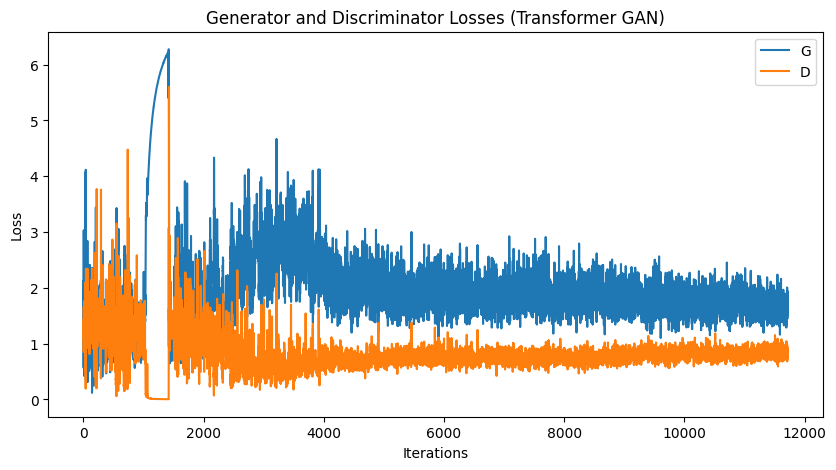

In [48]:
# Plot the loss curves for Generator and Discriminator

plt.figure(figsize=(10, 5))
plt.title("Generator and Discriminator Losses (Transformer GAN)")
plt.plot(G_losses_trans, label="G") # Plot the Generator's loss curve
plt.plot(D_losses_trans, label="D") # Plot the Descriminator's loss curve
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

At the beginning, the Generator’s loss increases sharply, indicating that it struggles to produce convincing images. Meanwhile, the Discriminator’s loss decreases, showing that it easily detects generated images as fake.

After this initial phase, the Generator’s loss stabilizes and oscillates, while the Discriminator’s loss remains relatively low but fluctuates. This suggests that the GAN is reaching an equilibrium where the Generator gradually improves to deceive the Discriminator, while the latter adjusts its ability to distinguish real from fake images.

Towards the end of training, the losses remain within relatively stable ranges, indicating that both networks continue to refine themselves, though the oscillations reflect an ongoing competitive dynamic.

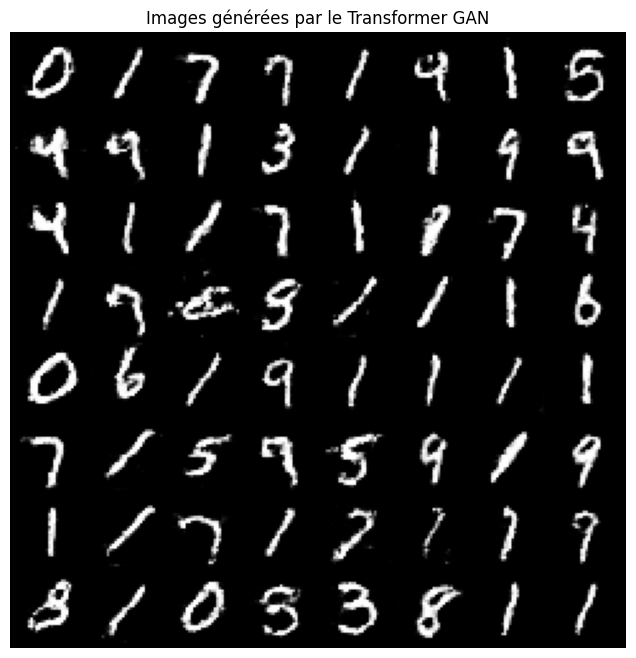

In [49]:
# Visualization of images generated during the last epoch

plt.figure(figsize=(8, 8))
plt.axis("off")
plt.title("Images générées par le Transformer GAN")
plt.imshow(np.transpose(img_list[-1], (1, 2, 0)))
plt.show()

The generated images show that the model has learned to produce recognizable digits, but with visible imperfections. Some digits are well-formed, while others appear blurry, distorted, or incomplete. This suggests that the Generator has acquired some understanding of digit structures but still lacks precision in generating fine details. Improvements in training, such as increasing the number of epochs or better stabilizing the losses, could help enhance the quality of the images.

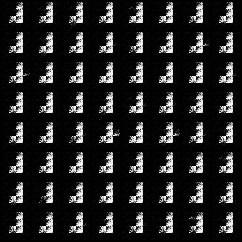

In [50]:
# Create a GIF showing the Generator's progress over epochs
pil_images = []
for epoch_grid in img_list:
    ndarr = epoch_grid.permute(1, 2, 0).cpu().numpy()
    ndarr = (ndarr * 255).astype(np.uint8)
    pil_images.append(Image.fromarray(ndarr))

pil_images[0].save(
    'part3_gan_transformer_progress.gif',
    save_all=True,
    append_images=pil_images[1:],
    duration=200,
    loop=0
)

IPyImage(filename='part3_gan_transformer_progress.gif')

---

## Conclusion Part 1, 2, 3

Overall, the three approaches successfully generate realistic handwritten digits on MNIST, but each has its own characteristics. The first method, based on CNNs (with transposed convolutions for the Generator and standard convolutions for the Discriminator), offers a relatively simple architecture to train and quickly produces high-quality images. The second method, which replaces CNNs with Transformers in both the Generator and the Discriminator, focuses more on global relationships (via multi-head attention); however, it can be more unstable during training, even though it ultimately manages to generate credible samples. The third method, which also employs a Transformer-based Generator–Discriminator pair, closely resembles the second in its implementation and yields visually comparable results while reaffirming the potential of Transformers for image generation. On this relatively simple dataset, the differences in quality between the generated images remain modest, but the Transformer approach demonstrates its ability to capture a global view of the image and offers promising prospects for extending to more complex tasks.